In [1]:
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

tfk = tf.keras
tfkl = tf.keras.layers

"""from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling3D, Conv3D, ConvLSTM2D, LSTM, AveragePooling2D
from keras.layers import Input, LSTM, Embedding, Dense, LeakyReLU, Flatten, Dropout, SeparableConv2D, GlobalAveragePooling3D
from keras.layers import TimeDistributed, BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import regularizers"""


from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.preprocessing import KBinsDiscretizer
import statistics


seed = 0

In [2]:
val_hists_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/dev_hists.npz')
val_hists_temp = val_hists_temp['data']

val_yields_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/dev_yields.npz')
val_yields_temp = val_yields_temp['data']

val_years_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/dev_years.npz')
val_years_temp = val_years_temp['data']

test_hists_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/test_hists.npz')
test_hists_temp = test_hists_temp['data']

test_yields_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/test_yields.npz')
test_yields_temp = test_yields_temp['data']

test_years_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/test_years.npz')
test_years_temp = test_years_temp['data']

train_hists_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/train_hists.npz')
train_hists_temp = train_hists_temp['data']

train_yields_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/train_yields.npz')
train_yields_temp = train_yields_temp['data']

train_years_temp = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/celsius/train_years.npz')
train_years_temp = train_years_temp['data']

In [3]:
years_temp = np.concatenate((train_years_temp, val_years_temp, test_years_temp))
hists_temp = np.concatenate((train_hists_temp, val_hists_temp, test_hists_temp))
yields_temp = np.concatenate((train_yields_temp, val_yields_temp, test_yields_temp))

del  train_years_temp, val_years_temp, test_years_temp
del  train_hists_temp, val_hists_temp, test_hists_temp
del  train_yields_temp, val_yields_temp, test_yields_temp

print(years_temp.shape)
print(hists_temp.shape)
print(yields_temp.shape)

df_years = pd.Series(years_temp)

df_years = df_years.astype('int')

(4347,)
(4347, 127, 45, 2)
(4347,)


In [4]:
val_hists_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/dev_hists.npz')
val_hists_refl = val_hists_refl['data']

val_yields_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/dev_yields.npz')
val_yields_refl = val_yields_refl['data']

val_years_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/dev_years.npz')
val_years_refl = val_years_refl['data']

test_hists_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/test_hists.npz')
test_hists_refl = test_hists_refl['data']

test_yields_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/test_yields.npz')
test_yields_refl = test_yields_refl['data']

test_years_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/test_years.npz')
test_years_refl = test_years_refl['data']

train_hists_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/train_hists.npz')
train_hists_refl = train_hists_refl['data']

train_yields_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/train_yields.npz')
train_yields_refl = train_yields_refl['data']

train_years_refl = np.load('/kaggle/input/temp-and-reflectance-for-yield-prediction/refl/train_years.npz')
train_years_refl = train_years_refl['data']

In [5]:
years_refl = np.concatenate((train_years_refl, val_years_refl, test_years_refl))
hists_refl = np.concatenate((train_hists_refl, val_hists_refl, test_hists_refl))
yields_refl = np.concatenate((train_yields_refl, val_yields_refl, test_yields_refl))

del train_years_refl, val_years_refl, test_years_refl
del train_hists_refl, val_hists_refl, test_hists_refl
del train_yields_refl, val_yields_refl, test_yields_refl

print(years_refl.shape)
print(hists_refl.shape)
print(yields_refl.shape)

df_years_refl = pd.Series(years_refl)

df_years_refl = df_years_refl.astype('int')

(4347,)
(4347, 127, 45, 7)
(4347,)


In [6]:
yields = yields_refl
years = years_refl
hists = np.concatenate((hists_refl,hists_temp),axis = 3)
del hists_refl,hists_temp
print(hists.shape)

(4347, 127, 45, 9)


In [7]:
index_test = df_years[df_years==2015].index.values
index_val = df_years[df_years==2016].index.values
index_train = df_years[df_years<2015].index.values

hists_train = hists[index_train,:,:,:]
hists_val = hists[index_val,:,:,:]
hists_test = hists[index_test,:,:,:]

yields_train = yields[index_train]
yields_val = yields[index_val]
yields_test = yields[index_test]

years_train = years[index_train]
years_val = years[index_val]
years_test = years[index_test]

print(years_train.shape)
print(years_val.shape)
print(years_test.shape)

(2971,)
(704,)
(672,)


0.24386510630674227
0.1886473464270839
0.21626812071992174
0.21175725855142458
0.0470576018189951
0.06758630090423241
0.178376756485776
-0.23112771149001315
-0.1777656048951062


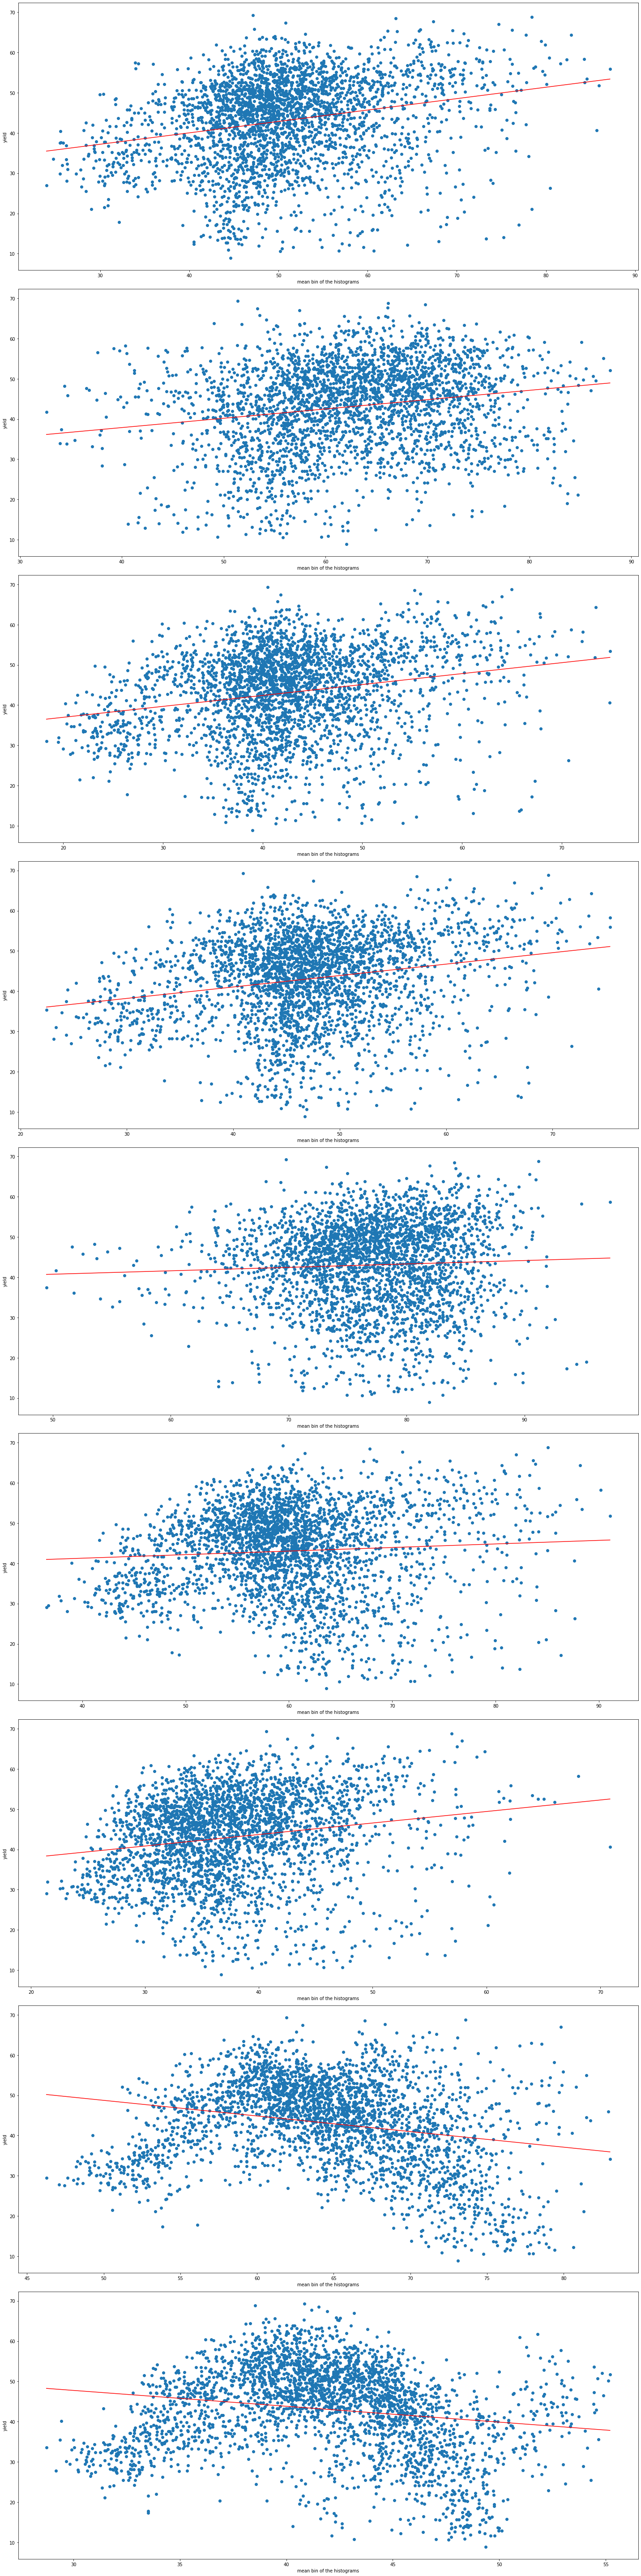

In [8]:
num_bands = hists_train.shape[3]
plt.figure(tight_layout = True, figsize= (20,80))
for band in range(num_bands):
    x = np.argmax(hists_train[:,:,:,band], axis= 1) # most frequent bin, i.e. the mode, for every year and image 
    x = np.mean(x, axis = 1) # average of the mode of all images for every year
    y = pd.Series(yields_train)
    x = pd.Series(x)
    print(x.corr(y))
    
    axes = plt.subplot(num_bands, 1, band+1)
    plt.scatter(x, y)
    plt.plot(np.unique(x),
         np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    #axes.set_title(('Day' if band == 0 else 'Night'))
    plt.ylabel('yield')
    plt.xlabel('mean bin of the histograms')

In [9]:
def build_model(input_shape, model_name):
    frames_input = Input(shape = input_shape, name= 'Input_layer')
    vision_model = Sequential(name = 'CNN_layers')
    vision_model.add(Conv1D(64, 2, 
                     activation='relu',
                     padding='same', name = 'convLayer',  input_shape = input_shape[1:]))
    vision_model.add(BatchNormalization(name = 'batchNorm'))
    vision_model.add(MaxPooling1D((2), name = 'maxPooling'))
    vision_model.add(Flatten())
    vision_model.add(BatchNormalization())
    encoded_frame_sequence = TimeDistributed(vision_model, name = 'CNN_wrapper') \
                                            (frames_input)
    encoded_video = LSTM(256, 
                         activation='tanh', 
                         return_sequences=True, name= 'LSTM') \
                         (encoded_frame_sequence)
    fc1 = Dense(64, activation='relu', name= 'Dense') \
               (encoded_video)
    out = Flatten(name= 'Flatten')(fc1)
    out = Dropout(0.5, name = 'Droput')(out)
    output = Dense(1, activation='relu',name= 'Output')(out)
    model = Model(inputs=frames_input, outputs=output, name = model_name)
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
    
    model.summary()
    
    return model

In [10]:
epochs = 300
batch_size = 64

In [11]:
callback = EarlyStopping(monitor='val_loss', patience=20)

In [12]:
def plot_history(history):
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.title('model mape')
    plt.ylabel('mean absolute percentage error')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

(2819,)
(757,)
(771,)


2022-12-28 10:43:48.508309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 10:43:48.598894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 10:43:48.599794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 10:43:48.601652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model_test_year_2011"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 127, 45, 9)]      0         
_________________________________________________________________
CNN_wrapper (TimeDistributed (None, 127, 1408)         7104      
_________________________________________________________________
LSTM (LSTM)                  (None, 127, 256)          1704960   
_________________________________________________________________
Dense (Dense)                (None, 127, 64)           16448     
_________________________________________________________________
Flatten (Flatten)            (None, 8128)              0         
_________________________________________________________________
Droput (Dropout)             (None, 8128)              0         
_________________________________________________________________
Output (Dense)               (None, 1)        

2022-12-28 10:43:51.914821: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 579981060 exceeds 10% of free system memory.
2022-12-28 10:43:52.560838: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 579981060 exceeds 10% of free system memory.
2022-12-28 10:43:53.045301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-12-28 10:43:55.913990: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


45/45 [==============================] - 13s 79ms/step - loss: 238.0935 - mae: 10.2107 - mape: 22.1883 - val_loss: 238.3838 - val_mae: 13.1863 - val_mape: 33.4755
Epoch 2/300
45/45 [==============================] - 3s 59ms/step - loss: 31.4577 - mae: 4.3509 - mape: 9.8186 - val_loss: 136.3468 - val_mae: 9.8576 - val_mape: 29.4626
Epoch 3/300
45/45 [==============================] - 3s 60ms/step - loss: 21.1844 - mae: 3.5375 - mape: 7.9808 - val_loss: 120.2263 - val_mae: 9.0710 - val_mape: 30.0385
Epoch 4/300
45/45 [==============================] - 3s 61ms/step - loss: 15.7857 - mae: 3.0809 - mape: 6.8782 - val_loss: 125.5615 - val_mae: 8.9182 - val_mape: 32.3388
Epoch 5/300
45/45 [==============================] - 3s 61ms/step - loss: 17.5095 - mae: 3.2923 - mape: 7.2928 - val_loss: 152.8053 - val_mae: 9.5766 - val_mape: 36.3341
Epoch 6/300
45/45 [==============================] - 3s 60ms/step - loss: 13.0419 - mae: 2.8119 - mape: 6.1858 - val_loss: 156.0416 - val_mae: 9.6622 - val_m

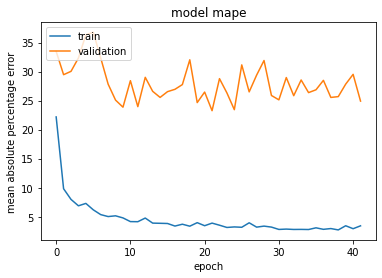

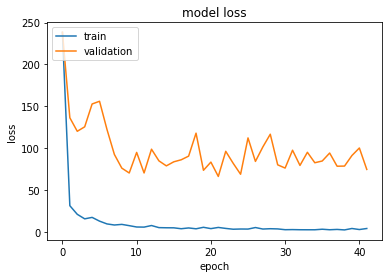

R^squared (wrong): 0.48180932
Mean absolute error:  6.4289913
Mean absolute percentage error:  20.187096
116671.73183984059
50790.78404410009
R2:  0.5646693226957289


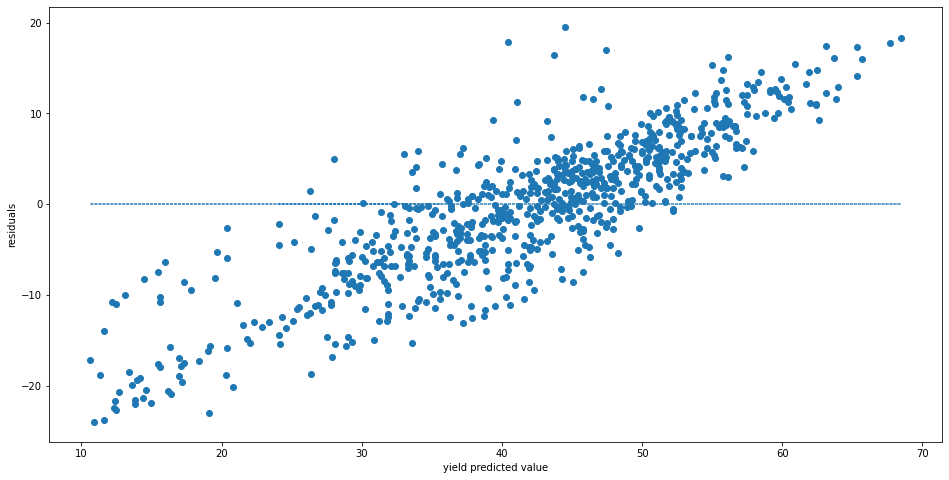

(2819,)
(771,)
(757,)
Model: "model_test_year_2012"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 127, 45, 9)]      0         
_________________________________________________________________
CNN_wrapper (TimeDistributed (None, 127, 1408)         7104      
_________________________________________________________________
LSTM (LSTM)                  (None, 127, 256)          1704960   
_________________________________________________________________
Dense (Dense)                (None, 127, 64)           16448     
_________________________________________________________________
Flatten (Flatten)            (None, 8128)              0         
_________________________________________________________________
Droput (Dropout)             (None, 8128)              0         
_________________________________________________________________
Output (Dense)          

2022-12-28 10:45:59.872450: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 579981060 exceeds 10% of free system memory.
2022-12-28 10:46:00.517806: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 579981060 exceeds 10% of free system memory.


Epoch 1/300
45/45 [==============================] - 5s 77ms/step - loss: 222.7913 - mae: 10.0964 - mape: 22.1535 - val_loss: 308.2140 - val_mae: 15.3539 - val_mape: 36.3137
Epoch 2/300
45/45 [==============================] - 3s 59ms/step - loss: 30.8939 - mae: 4.2592 - mape: 9.6465 - val_loss: 163.3779 - val_mae: 10.6599 - val_mape: 28.8771
Epoch 3/300
45/45 [==============================] - 3s 59ms/step - loss: 20.8084 - mae: 3.5107 - mape: 7.8806 - val_loss: 143.7099 - val_mae: 9.8663 - val_mape: 28.0820
Epoch 4/300
45/45 [==============================] - 3s 60ms/step - loss: 17.3845 - mae: 3.2444 - mape: 7.2419 - val_loss: 139.3771 - val_mae: 9.7030 - val_mape: 27.5281
Epoch 5/300
45/45 [==============================] - 3s 60ms/step - loss: 14.0310 - mae: 2.9222 - mape: 6.4580 - val_loss: 123.6056 - val_mae: 8.9784 - val_mape: 26.5849
Epoch 6/300
45/45 [==============================] - 3s 62ms/step - loss: 12.2617 - mae: 2.7408 - mape: 6.0077 - val_loss: 98.0880 - val_mae: 7.5

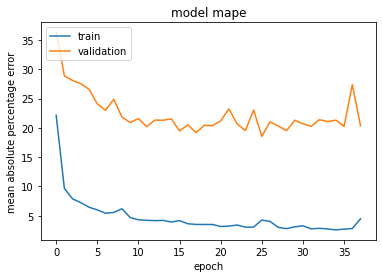

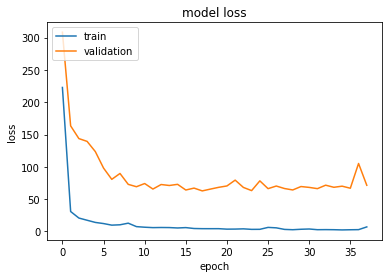

R^squared (wrong): 0.5194781
Mean absolute error:  6.20329
Mean absolute percentage error:  20.679329
151081.52658688874
44353.620796336356
R2:  0.7064259158724606


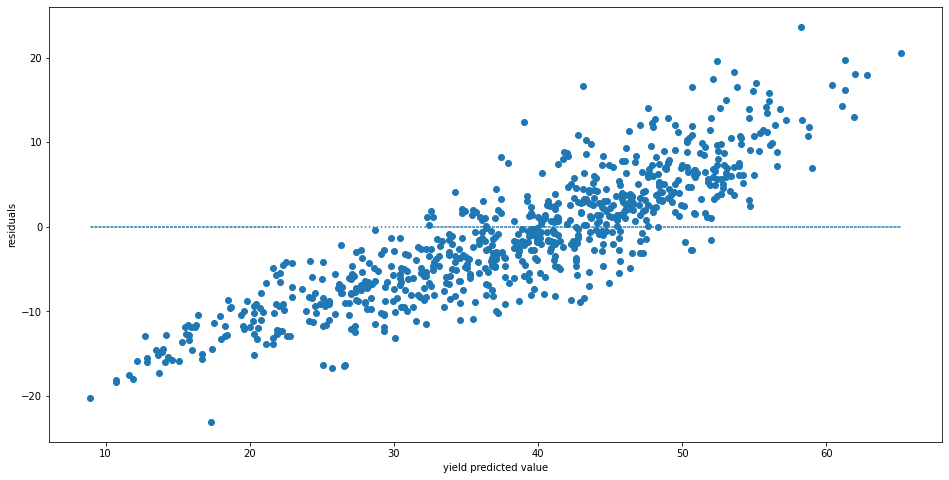

(2875,)
(757,)
(715,)
Model: "model_test_year_2013"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 127, 45, 9)]      0         
_________________________________________________________________
CNN_wrapper (TimeDistributed (None, 127, 1408)         7104      
_________________________________________________________________
LSTM (LSTM)                  (None, 127, 256)          1704960   
_________________________________________________________________
Dense (Dense)                (None, 127, 64)           16448     
_________________________________________________________________
Flatten (Flatten)            (None, 8128)              0         
_________________________________________________________________
Droput (Dropout)             (None, 8128)              0         
_________________________________________________________________
Output (Dense)          

2022-12-28 10:48:28.338879: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 591502500 exceeds 10% of free system memory.


Epoch 1/300
45/45 [==============================] - 6s 80ms/step - loss: 225.0813 - mae: 10.0527 - mape: 23.3626 - val_loss: 228.7102 - val_mae: 12.9000 - val_mape: 32.9977
Epoch 2/300
45/45 [==============================] - 3s 60ms/step - loss: 27.7131 - mae: 4.0143 - mape: 9.6146 - val_loss: 143.0051 - val_mae: 10.1214 - val_mape: 29.6306
Epoch 3/300
45/45 [==============================] - 3s 60ms/step - loss: 19.0494 - mae: 3.3573 - mape: 7.8672 - val_loss: 124.5013 - val_mae: 9.3298 - val_mape: 29.5392
Epoch 4/300
45/45 [==============================] - 3s 60ms/step - loss: 15.1952 - mae: 3.0031 - mape: 6.9715 - val_loss: 120.3402 - val_mae: 9.1359 - val_mape: 29.6585
Epoch 5/300
45/45 [==============================] - 3s 60ms/step - loss: 12.4418 - mae: 2.7282 - mape: 6.3125 - val_loss: 119.0722 - val_mae: 8.6462 - val_mape: 31.4253
Epoch 6/300
45/45 [==============================] - 3s 61ms/step - loss: 10.2642 - mae: 2.4863 - mape: 5.7006 - val_loss: 109.4085 - val_mae: 8.

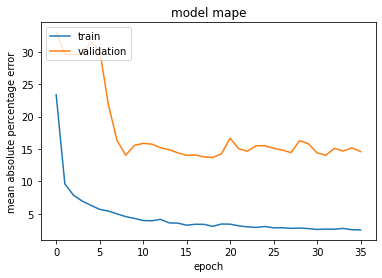

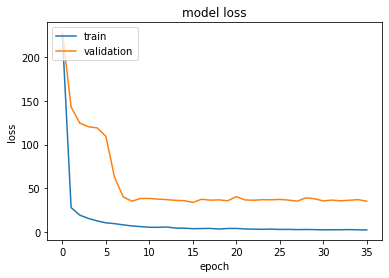

R^squared (wrong): 0.61488914
Mean absolute error:  4.2798314
Mean absolute percentage error:  11.283001
62294.14740319468
23218.716625763205
R2:  0.6272729045397857


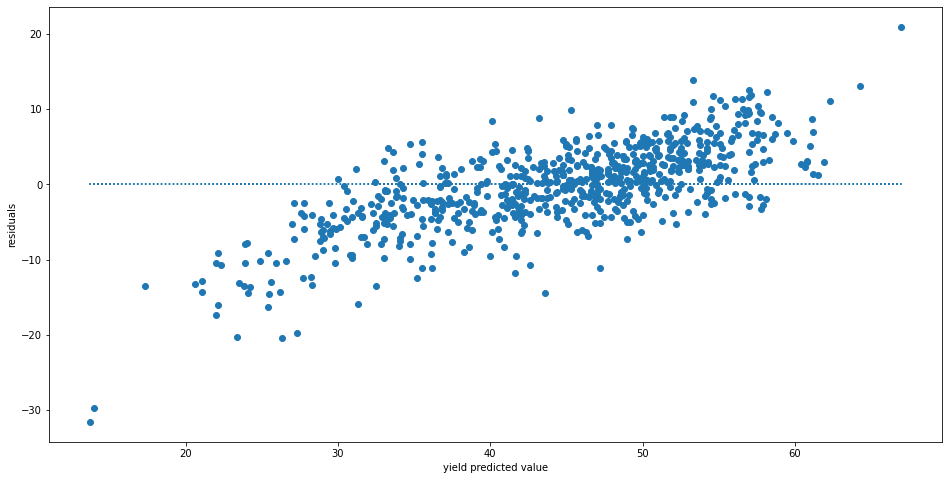

(2904,)
(715,)
(728,)
Model: "model_test_year_2014"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 127, 45, 9)]      0         
_________________________________________________________________
CNN_wrapper (TimeDistributed (None, 127, 1408)         7104      
_________________________________________________________________
LSTM (LSTM)                  (None, 127, 256)          1704960   
_________________________________________________________________
Dense (Dense)                (None, 127, 64)           16448     
_________________________________________________________________
Flatten (Flatten)            (None, 8128)              0         
_________________________________________________________________
Droput (Dropout)             (None, 8128)              0         
_________________________________________________________________
Output (Dense)          

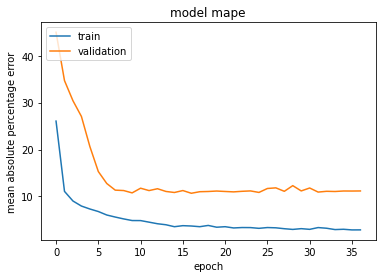

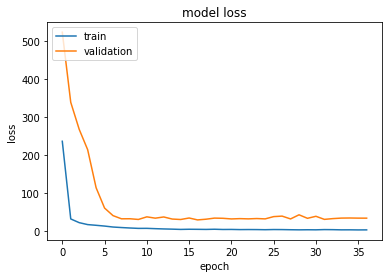

R^squared (wrong): 0.67546105
Mean absolute error:  4.1642475
Mean absolute percentage error:  9.339086
68351.74866132058
20609.84508041566
R2:  0.698473770107384


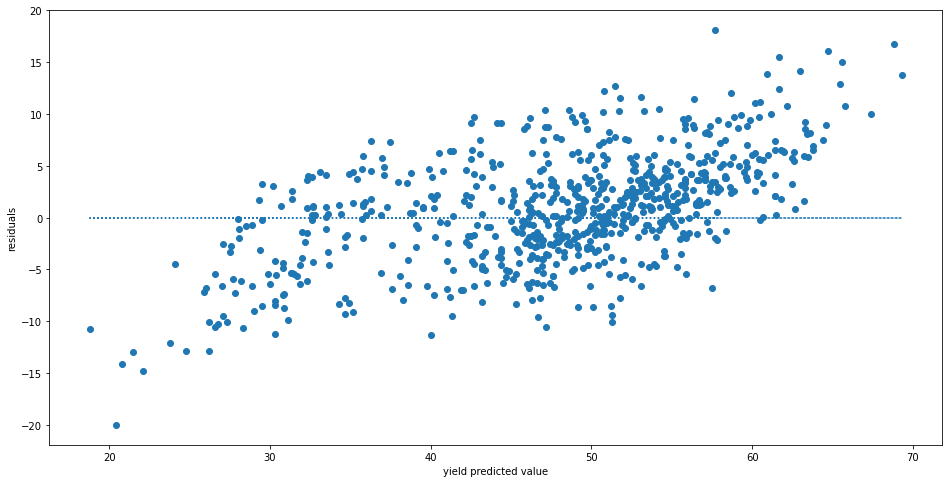

(2947,)
(728,)
(672,)
Model: "model_test_year_2015"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 127, 45, 9)]      0         
_________________________________________________________________
CNN_wrapper (TimeDistributed (None, 127, 1408)         7104      
_________________________________________________________________
LSTM (LSTM)                  (None, 127, 256)          1704960   
_________________________________________________________________
Dense (Dense)                (None, 127, 64)           16448     
_________________________________________________________________
Flatten (Flatten)            (None, 8128)              0         
_________________________________________________________________
Droput (Dropout)             (None, 8128)              0         
_________________________________________________________________
Output (Dense)          

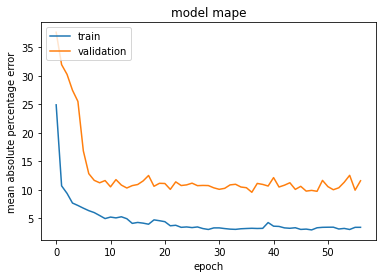

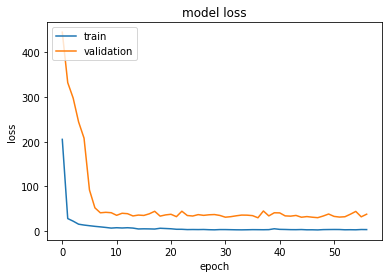

R^squared (wrong): 0.46936548
Mean absolute error:  5.327235
Mean absolute percentage error:  12.530036
71887.88705037128
32248.852606600136
R2:  0.5514007445509754


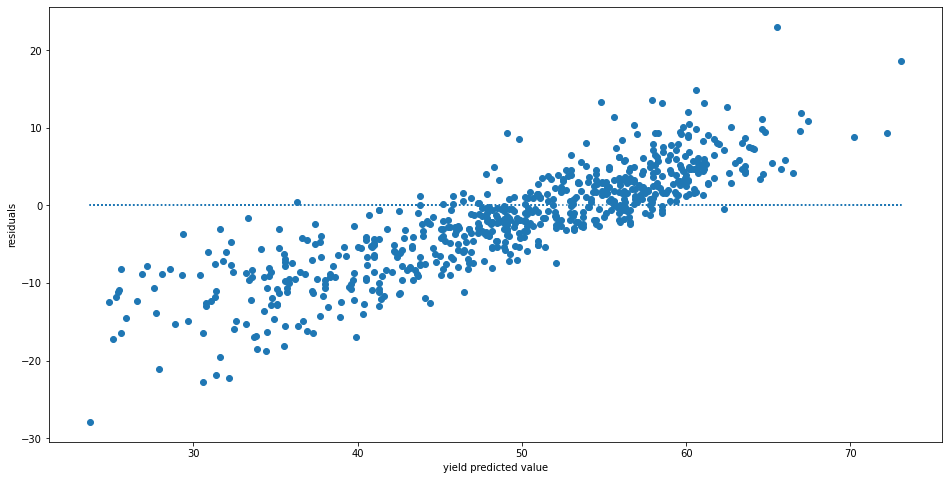

(2971,)
(672,)
(704,)
Model: "model_test_year_2016"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 127, 45, 9)]      0         
_________________________________________________________________
CNN_wrapper (TimeDistributed (None, 127, 1408)         7104      
_________________________________________________________________
LSTM (LSTM)                  (None, 127, 256)          1704960   
_________________________________________________________________
Dense (Dense)                (None, 127, 64)           16448     
_________________________________________________________________
Flatten (Flatten)            (None, 8128)              0         
_________________________________________________________________
Droput (Dropout)             (None, 8128)              0         
_________________________________________________________________
Output (Dense)          

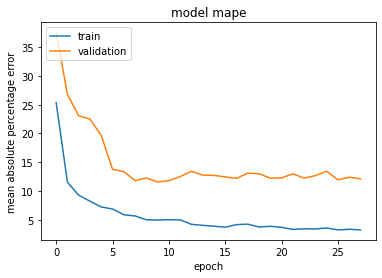

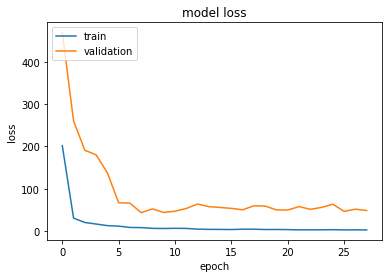

R^squared (wrong): -0.69327366
Mean absolute error:  8.968013
Mean absolute percentage error:  16.139854
112736.31033007689
77488.44159888552
R2:  0.31265764000959684


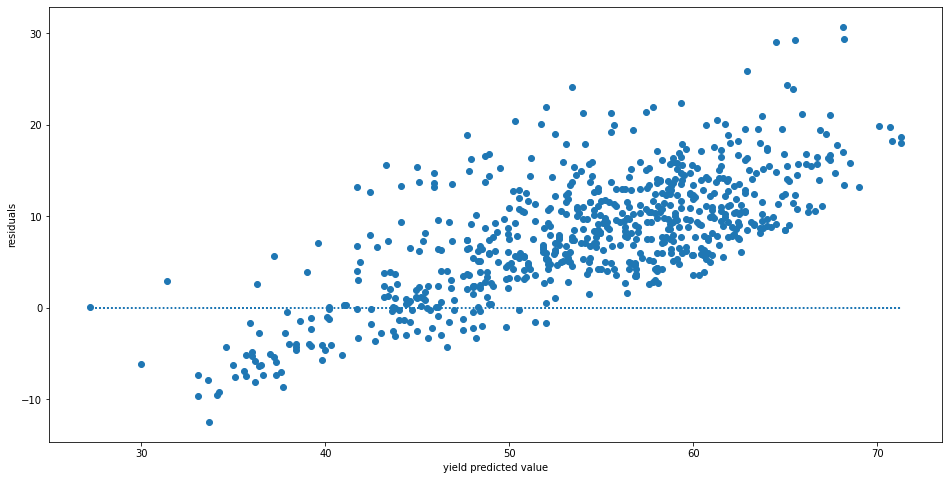

In [13]:
mae_scores = []
mape_scores = []
r_wrong_scores = [] # we call it wrong because the TSS is actually 
                    # computed looking at all the yields of the test year, a data not accessible the year before
r_square = []
predictions = []
residuals = []
for year in range(2011,2017):
    
    index_test = df_years[df_years==year].index.values
    if year == 2011:
        val_year = 2012
        index_val = df_years[df_years==val_year].index.values
    else:
        val_year = year-1
        index_val = df_years[df_years==val_year].index.values

    index_train = df_years[(df_years!=year) & (df_years!=val_year)].index.values

    hists_train = hists[index_train,:,:,:]
    hists_val = hists[index_val,:,:,:]
    hists_test = hists[index_test,:,:,:]

    yields_train = yields[index_train]
    yields_val = yields[index_val]
    yields_test = yields[index_test]

    years_train = years[index_train]
    years_val = years[index_val]
    years_test = years[index_test]

    print(years_train.shape)
    print(years_val.shape)
    print(years_test.shape)

    model = build_model(hists_train.shape[1:], model_name = 'model_test_year_' + str(year))
    history = model.fit(x = hists_train, y = yields_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=1,
                        validation_data = (hists_val,yields_val),
                        callbacks=callback)
    
    plot_history(history)
    
    yields_test = yields_test.reshape(yields_test.shape[0])
    y_pred = model.predict(x = hists_test)
    y_pred = y_pred.reshape(y_pred.shape[0])
    y_true = yields_test
    predictions.append(y_pred)
    
    r_squared = tfa.metrics.r_square.RSquare()
    r_squared.update_state(y_true, y_pred)
    result = r_squared.result().numpy()
    r_wrong_scores.append(result)
    print('R^squared (wrong):' , result)

    mae = tfk.metrics.MeanAbsoluteError()
    mae.update_state(y_true,y_pred)
    result = mae.result().numpy()
    mae_scores.append(result)
    print('Mean absolute error: ',result)

    mape = tf.keras.metrics.MeanAbsolutePercentageError()
    mape.update_state(y_true,y_pred)
    result = mape.result().numpy()
    mape_scores.append(result)
    print('Mean absolute percentage error: ', result)
    
    diff = y_true - y_pred
    residuals.append(abs(diff)/y_true)
    
    y_mean = np.concatenate((yields_train,yields_val)).mean()
    
    tss = np.square(y_true-y_mean).sum()
    print(tss)
    rss = np.square(diff).sum()
    print(rss)
    r2 = 1-(rss/tss)
    r_square.append(r2)
    print('R2: ', r2)

    plt.figure(figsize=(16,8))
    plt.scatter(y_true, diff)
    plt.plot(y_true, np.zeros(len(y_true)),':')

    plt.ylabel('residuals')
    plt.xlabel('yield predicted value')
    plt.show()
        

In [14]:
# salva i valori predetti, e gli errori, poi crei i bin e ci metti gli errori e calcoli la media
predictions_re = np.concatenate(predictions).reshape(-1,1)
residuals_re = np.concatenate(residuals)
est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
bin_indexes  = est.fit_transform(predictions_re).reshape(-1)
residual_intervals =  [ [] for _ in range(20) ]

for i,residual in enumerate(residuals_re):
    index = int(bin_indexes[i])
    residual_intervals[index].append(residual)

std_devs = []
for d in residual_intervals:
    std_devs.append(statistics.mean(d))

std_devs = np.asarray(std_devs)
#std_devs = std_devs/2

In [15]:
print (statistics.mean(std_devs))
print (statistics.mean(mae_scores))
print (statistics.mean(mape_scores))
print (statistics.mean(r_wrong_scores))
print (statistics.mean(r_square))

0.1515129904871483
5.895268
15.026401
0.34462157
0.5768167162959885


In [16]:
bad_yield, avg_yield = np.quantile(yields, q = [0.25,0.5])
print(bad_yield, avg_yield)

38.7 47.2


In [17]:
estimated_visits_saved = []
accuracies = []
visits_saved_list = []
for year in range(2012,2016):
    
    
    index_test = df_years[df_years==year].index.values
    if year == 2011:
        val_year = 2012
        index_val = df_years[df_years==val_year].index.values
    else:
        val_year = year-1
        index_val = df_years[df_years==val_year].index.values

    index_train = df_years[(df_years!=year) & (df_years!=val_year)].index.values
    hists_train = hists[index_train,:,:,:]
    hists_val = hists[index_val,:,:,:]
    hists_test = hists[index_test,:,:,:]

    yields_train = yields[index_train]
    yields_val = yields[index_val]
    yields_test = yields[index_test]

    years_train = years[index_train]
    years_val = years[index_val]
    years_test = years[index_test]

    print(years_train.shape)
    print(years_val.shape)
    print(years_test.shape)
    
    model = build_model(hists_train.shape[1:], model_name = 'model_test_year_' + str(year))
    history = model.fit(x = hists_train, y = yields_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=0,
                        validation_data = (hists_val,yields_val),
                        callbacks=callback)
    
    y_true = yields_test
    y_pred = model.predict(hists_test)
    index = est.transform(y_pred).reshape(-1)
    index = [int(x) for x in index]
    std_dev_test = std_devs[index]
    
    no_visit_count = 0
    visit_count = 0
    true_count = 0

    for i,y in enumerate(y_pred):
        if (y-(std_dev_test[i]*y)) > avg_yield:
            continue
        if abs(bad_yield-y)>(std_dev_test[i]*y):
            no_visit_count+=1
        else:
            visit_count+=1
        if abs(y-y_true[i])<=(std_dev_test[i]*y):
            true_count+=1

    visits_saved = no_visit_count/(visit_count+no_visit_count)
    accuracy = true_count/(visit_count+no_visit_count)

    print('year: ', year)
    print(no_visit_count)
    print(visit_count)
    print(visits_saved)
    print(true_count)
    print(accuracy)
    print(visits_saved*accuracy)
    accuracies.append(accuracy)
    visits_saved_list.append(visits_saved)
    estimated_visits_saved.append(visits_saved*accuracy)
    
print('estimated visits saved,mean accuracy and mean visits saved :')
print(statistics.mean(estimated_visits_saved))
print(statistics.mean(accuracies))
print(statistics.mean(visits_saved_list))


(2819,)
(771,)
(757,)
Model: "model_test_year_2012"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 127, 45, 9)]      0         
_________________________________________________________________
CNN_wrapper (TimeDistributed (None, 127, 1408)         7104      
_________________________________________________________________
LSTM (LSTM)                  (None, 127, 256)          1704960   
_________________________________________________________________
Dense (Dense)                (None, 127, 64)           16448     
_________________________________________________________________
Flatten (Flatten)            (None, 8128)              0         
_________________________________________________________________
Droput (Dropout)             (None, 8128)              0         
_________________________________________________________________
Output (Dense)          